In [46]:
import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import lightgbm as lgb

In [2]:
train = pd.read_pickle('features/train_created_feature.pkl')

In [3]:
print(train.shape)
train.head()

(58327370, 47)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,shifted_sales_t31,shifted_sell_price_t31,shifted_sales_t33,shifted_sell_price_t33,shifted_sales_t35,shifted_sell_price_t35,shifted_sales_t42,shifted_sell_price_t42,shifted_sales_t56,shifted_sell_price_t56
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.dtypes

id                                object
item_id                            int16
dept_id                             int8
cat_id                              int8
store_id                            int8
state_id                            int8
d                                 object
sales                              int16
date                      datetime64[ns]
wm_yr_wk                           int16
wday                                int8
month                               int8
event_name_1                        int8
event_type_1                        int8
event_name_2                        int8
event_type_2                        int8
snap_CA                             int8
snap_TX                             int8
snap_WI                             int8
quarter                             int8
week                                int8
day                                 int8
dayofweek                           int8
is_year_end                         int8
is_year_start   

In [5]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, dt_col="date"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.dt_col = dt_col

    def split(self, X, y=None, groups=None):
        sec = (X[self.dt_col] - X[self.dt_col][0]).dt.total_seconds()
        duration = sec.max() - sec.min()

        train_sec = 3600 * 24 * self.train_days
        test_sec = 3600 * 24 * self.test_days
        total_sec = test_sec + train_sec
        step = (duration - total_sec) / (self.n_splits - 1)

        for idx in range(self.n_splits):
            train_start = idx * step
            train_end = train_start + train_sec
            test_end = train_end + test_sec

            if idx == self.n_splits - 1:
                test_mask = sec >= train_end
            else:
                test_mask = (sec >= train_end) & (sec < test_end)

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = (sec >= train_end) & (sec < test_end)

            yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits


def plot_cv_indices(cv, X, y, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    fig, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    fig.savefig("figure/cv_indices.png")

In [20]:
cv_params = {
        "n_splits": 5,
        "train_days": 365 * 2,
        "test_days": 28,
        "dt_col": 'date',
    }
cv = CustomTimeSeriesSplitter(**cv_params)

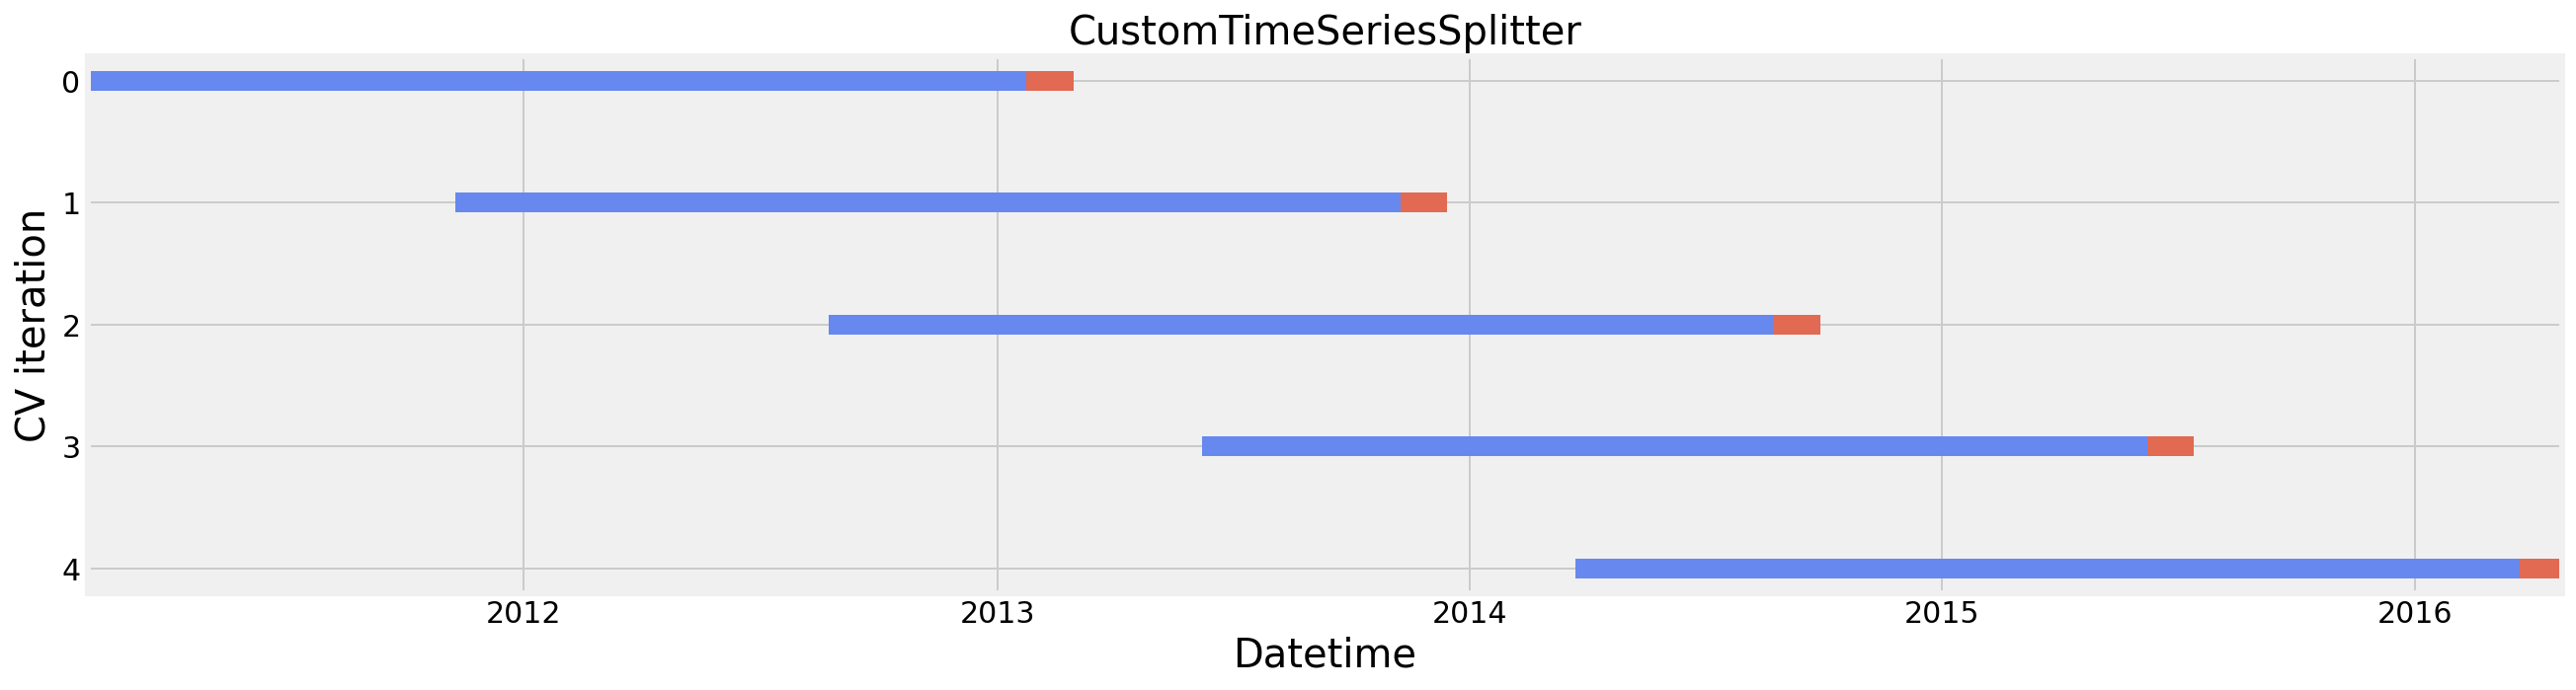

In [21]:
plot_cv_indices(cv, train.iloc[::1000][['date']].reset_index(drop=True), None, 'date')

In [41]:
features = train.columns.tolist()
cols_to_drop = ['id', 'd', 'date', 'sales']

features = [f for f in features if f not in cols_to_drop]

PRED_INTERVAL = 28
eval_date = train['date'].max() - datetime.timedelta(days=PRED_INTERVAL)
mask = train["date"] <= "2016-04-24"

X, y = train[mask][['date'] + features], train[mask]['sales']
X_eval, y_eval = train[~mask][['date'] + features], train[~mask]['sales']

In [42]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n---------- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) ----------\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(X_trn.drop(drop_when_train, axis=1), label=y_trn)
        val_set = lgb.Dataset(X_val.drop(drop_when_train, axis=1), label=y_val)

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models

In [ ]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "objective": "regression",
    "n_jobs": -1,
    "seed": 42,
    "learning_rate": 0.1,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

models = train_lgb(
    bst_params, fit_params, X, y, cv, drop_when_train=['date']
)

# del X_train, y_train
# gc.collect()


---------- Fold: (1 / 5) ----------



In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
imp_type = "gain"
importances = np.zeros(X_test.shape[1])
preds = np.zeros(X_test.shape[0])

for model in models:
    preds += model.predict(X_test)
    importances += model.feature_importance(imp_type)

preds = preds / cv.get_n_splits()
importances = importances / cv.get_n_splits()